<a href="https://colab.research.google.com/github/sriharshamutnuru/AI_Learning/blob/main/Day11_PromptValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



🚀 Running Example 1 ...

🚀 Running Example 2 ...

🚀 Running Example 3 ...

🚀 Running Example 4 ...

🚀 Running Example 5 ...

🚀 Running Example 6 ...

🚀 Running Example 7 ...

🚀 Running Example 8 ...

🚀 Running Example 9 ...

🚀 Running Example 10 ...

🚀 Running Example 11 ...

🚀 Running Example 12 ...

🚀 Running Example 13 ...

🚀 Running Example 14 ...

🚀 Running Example 15 ...

🚀 Running Example 16 ...

🚀 Running Example 17 ...

🚀 Running Example 18 ...

🚀 Running Example 19 ...

🚀 Running Example 20 ...

✅ Evaluation Complete. Results saved to 'evaluation_report.csv'.


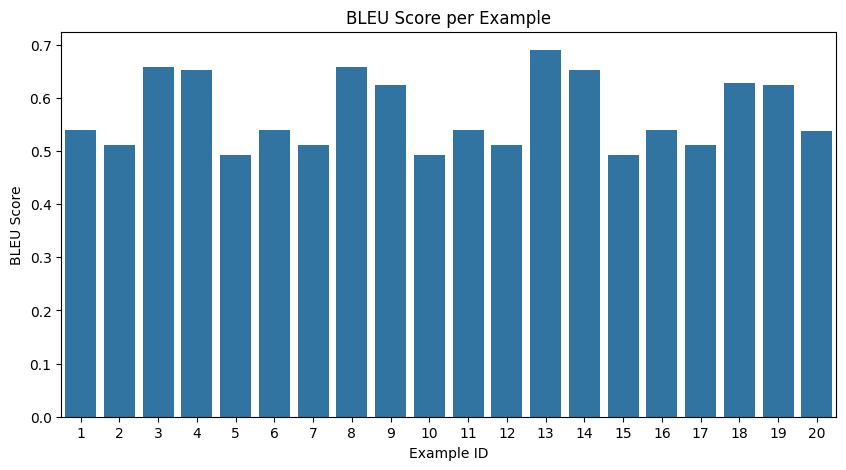

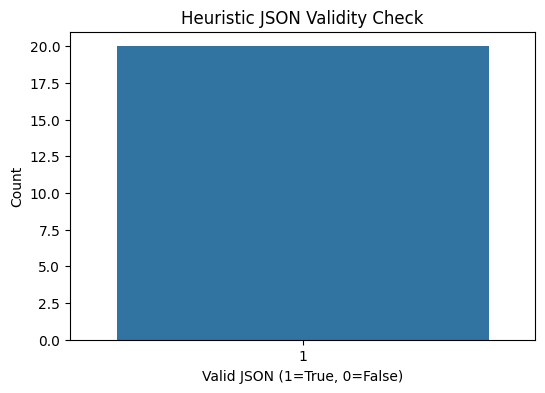


📊 Top Performing Examples (by BLEU):
    id                                            context  bleu_score  \
12  13  Data ingestion job failed because of schema mi...       0.690   
2    3  Data ingestion job failed because of schema mi...       0.658   
7    8  Data ingestion job failed because of schema mi...       0.658   
3    4  Azure Key Vault access denied errors during se...       0.652   
13  14  Azure Key Vault access denied errors during se...       0.652   

    heuristic_valid  
12                1  
2                 1  
7                 1  
3                 1  
13                1  

⚠️ Lowest Performing Examples (by BLEU):
    id                                            context  bleu_score  \
4    5       Spark job fails due to out-of-memory errors.       0.493   
9   10       Spark job fails due to out-of-memory errors.       0.493   
14  15       Spark job fails due to out-of-memory errors.       0.493   
1    2  ETL pipeline is slow because of large shuffle ...

In [2]:
# ============================================================
# 📘 Day 11 — Evaluating Prompts (Automatic Checks + Visualization)
# Fixed NLTK punkt_tab issue
# ============================================================

!pip install --quiet openai==1.109.1 pandas nltk matplotlib seaborn

from openai import OpenAI
from google.colab import userdata
import pandas as pd
import json
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Fix NLTK resource errors
nltk.download('punkt')
nltk.download('punkt_tab')

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
MODEL = "gpt-4o-mini"

# --- Step 1: Prompt Template Function ---
def build_prompt(context: str, instructions: str, examples: list = None) -> str:
    base_prompt = f"You are an intelligent assistant.\n\nTask:\n{instructions}\n\n"

    if examples:
        base_prompt += "Examples:\n"
        for i, ex in enumerate(examples, 1):
            base_prompt += f"Example {i}:\nInput: {ex['input']}\nOutput: {ex['output']}\n\n"

    base_prompt += f"Context:\n{context}\n\nReturn the result in valid JSON.\n"
    return base_prompt

# --- Step 2: Dataset (20 Examples Simulated) ---
data = [
    {"context": "Azure backup job fails due to storage timeouts.", "expected": {"problem": "backup timeout", "solution": "increase timeout or optimize storage connection"}},
    {"context": "ETL pipeline is slow because of large shuffle operations.", "expected": {"problem": "shuffle bottleneck", "solution": "increase shuffle partitions or memory"}},
    {"context": "Data ingestion job failed because of schema mismatch between source and target.", "expected": {"problem": "schema mismatch", "solution": "validate schema or map fields"}},
    {"context": "Azure Key Vault access denied errors during secret retrieval.", "expected": {"problem": "access denied", "solution": "check access policies in Key Vault"}},
    {"context": "Spark job fails due to out-of-memory errors.", "expected": {"problem": "memory overflow", "solution": "increase executor memory or optimize caching"}},
] * 4  # Duplicate to simulate 20 examples

instructions = "Extract the main problem and its solution from the given context."
examples = [
    {"input": "System performance drops when too many concurrent jobs run.", "output": '{"problem": "performance degradation", "solution": "limit concurrent jobs"}'}
]

# --- Step 3: Evaluation Functions ---
def get_model_output(context):
    prompt = build_prompt(context, instructions, examples)
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are a structured JSON generator."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
    )
    return response.choices[0].message.content.strip()

def exact_match(pred, gold):
    return 1 if pred.strip().lower() == gold.strip().lower() else 0

def bleu_score(pred, gold):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([nltk.word_tokenize(gold)], nltk.word_tokenize(pred), smoothing_function=smoothie)

def heuristic_check(pred):
    try:
        obj = json.loads(pred)
        return int("problem" in obj and "solution" in obj)
    except:
        return 0

# --- Step 4: Evaluate All Examples ---
results = []
for i, row in enumerate(data, 1):
    print(f"\n🚀 Running Example {i} ...")
    pred = get_model_output(row['context'])
    gold = json.dumps(row['expected'])

    em = exact_match(pred, gold)
    bleu = bleu_score(pred, gold)
    heuristic = heuristic_check(pred)

    results.append({
        "id": i,
        "context": row['context'],
        "expected": gold,
        "predicted": pred,
        "exact_match": em,
        "bleu_score": round(bleu, 3),
        "heuristic_valid": heuristic
    })

df = pd.DataFrame(results)
df.to_csv("evaluation_report.csv", index=False)
print("\n✅ Evaluation Complete. Results saved to 'evaluation_report.csv'.")

# --- Step 5: Visualization ---
plt.figure(figsize=(10,5))
sns.barplot(x="id", y="bleu_score", data=df)
plt.title("BLEU Score per Example")
plt.xlabel("Example ID")
plt.ylabel("BLEU Score")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="heuristic_valid", data=df)
plt.title("Heuristic JSON Validity Check")
plt.xlabel("Valid JSON (1=True, 0=False)")
plt.ylabel("Count")
plt.show()

# --- Step 6: Summary Table ---
print("\n📊 Top Performing Examples (by BLEU):")
print(df.nlargest(5, 'bleu_score')[['id','context','bleu_score','heuristic_valid']])

print("\n⚠️ Lowest Performing Examples (by BLEU):")
print(df.nsmallest(5, 'bleu_score')[['id','context','bleu_score','heuristic_valid']])
